+ 从 sklearn 官网下载的人脸识别案例

http://scikit-learn.org/stable/auto_examples/applications/plot_face_recognition.html






参考资料：

解决 sklearn 中 fetch_lfw_people 安装失败问题  
https://blog.csdn.net/pyufftj/article/details/79756327

In [1]:
%matplotlib inline


# Faces recognition example using eigenfaces and SVMs


The dataset used in this example is a preprocessed excerpt of the
"Labeled Faces in the Wild", aka LFW_:

  http://vis-www.cs.umass.edu/lfw/lfw-funneled.tgz (233MB)


Expected results for the top 5 most represented people in the dataset:

================== ============ ======= ========== =======
                   precision    recall  f1-score   support
================== ============ ======= ========== =======
     Ariel Sharon       0.67      0.92      0.77        13
     Colin Powell       0.75      0.78      0.76        60
  Donald Rumsfeld       0.78      0.67      0.72        27
    George W Bush       0.86      0.86      0.86       146
Gerhard Schroeder       0.76      0.76      0.76        25
      Hugo Chavez       0.67      0.67      0.67        15
       Tony Blair       0.81      0.69      0.75        36

      avg / total       0.80      0.80      0.80       322
================== ============ ======= ========== =======




In [20]:
from __future__ import print_function

from time import time
import logging
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import fetch_lfw_people
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.decomposition import PCA
from sklearn.svm import SVC


print(__doc__)

# Display progress logs on stdout
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(message)s')

Automatically created module for IPython interactive environment


In [21]:

# #############################################################################
# Download the data, if not already on disk and load it as numpy arrays

lfw_people = fetch_lfw_people(min_faces_per_person=70, resize=0.4)

2018-10-17 09:52:49,239 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976012
2018-10-17 09:52:58,224 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976009
2018-10-17 09:53:01,144 Downloading LFW metadata: https://ndownloader.figshare.com/files/5976006
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/misc/pilutil.py:480: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if issubdtype(ts, int):
/Users/liwei/anaconda3/envs/ipykernel_py3/lib/python3.6/site-packages/scipy/misc/pilutil.py:483: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif issubdtype(type(size), float):


In [22]:
dir(lfw_people)

['DESCR', 'data', 'images', 'target', 'target_names']

In [23]:
# introspect the images arrays to find the shapes (for plotting)
n_samples, h, w = lfw_people.images.shape

In [24]:
n_samples

1288

In [25]:
h

50

In [26]:
w

37

In [27]:
# for machine learning we use the 2 data directly (as relative pixel
# positions info is ignored by this model)
X = lfw_people.data
n_features = X.shape[1]

In [28]:
X.shape

(1288, 1850)

In [29]:
# the label to predict is the id of the person
y = lfw_people.target

In [30]:
np.unique(y)

array([0, 1, 2, 3, 4, 5, 6])

In [31]:
target_names = lfw_people.target_names
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [32]:
target_names.shape

(7,)

In [33]:
target_names = lfw_people.target_names
n_classes = target_names.shape[0]

print("Total dataset size:")
print("n_samples: %d" % n_samples)
print("n_features: %d" % n_features)
print("n_classes: %d" % n_classes)


Total dataset size:
n_samples: 1288
n_features: 1850
n_classes: 7


In [35]:
# #############################################################################
# Split into a training set and a test set using a stratified k fold

# split into a training and testing set
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42)

In [49]:
X_train.shape, X_test.shape

((966, 1850), (322, 1850))

In [52]:
X_train.min(), X_train.max()

(0.0, 255.0)

liwei 注：从 1850 维抽取特征，最后剩下 150 维。

In [36]:
# #############################################################################
# Compute a PCA (eigenfaces) on the face dataset (treated as unlabeled
# dataset): unsupervised feature extraction / dimensionality reduction
n_components = 150

In [37]:
print("Extracting the top %d eigenfaces from %d faces"
      % (n_components, X_train.shape[0]))

Extracting the top 150 eigenfaces from 966 faces


In [38]:
t0 = time()
pca = PCA(n_components=n_components, svd_solver='randomized',
          whiten=True).fit(X_train)
print("done in %0.3fs" % (time() - t0))

done in 0.118s


liwei 注：`pca.components_` 是一个矩阵，每一行表示一个主成分，每一个主成分有 1850 维，一共保留了 150 个主成分。

In [41]:
pca.components_.shape

(150, 1850)

In [40]:
eigenfaces = pca.components_.reshape((n_components, h, w))

In [42]:
print("Projecting the input data on the eigenfaces orthonormal basis")
t0 = time()
X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)
print("done in %0.3fs" % (time() - t0))

Projecting the input data on the eigenfaces orthonormal basis
done in 0.014s


## 通过网格搜索，找到最好的超参数

In [43]:
# #############################################################################
# Train a SVM classification model

print("Fitting the classifier to the training set")
t0 = time()
param_grid = {'C': [1e3, 5e3, 1e4, 5e4, 1e5],
              'gamma': [0.0001, 0.0005, 0.001, 0.005, 0.01, 0.1], }
clf = GridSearchCV(SVC(kernel='rbf', class_weight='balanced'), param_grid)
clf = clf.fit(X_train_pca, y_train)
print("done in %0.3fs" % (time() - t0))
print("Best estimator found by grid search:")
print(clf.best_estimator_)

Fitting the classifier to the training set
done in 21.114s
Best estimator found by grid search:
SVC(C=1000.0, cache_size=200, class_weight='balanced', coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma=0.001, kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)


liwei 注：这里直接使用网格搜索得到的分类器做预测。

In [44]:
# #############################################################################
# Quantitative evaluation of the model quality on the test set

print("Predicting people's names on the test set")
t0 = time()
y_pred = clf.predict(X_test_pca)
print("done in %0.3fs" % (time() - t0))

Predicting people's names on the test set
done in 0.041s


In [45]:
print(classification_report(y_test, y_pred, target_names=target_names))

                   precision    recall  f1-score   support

     Ariel Sharon       0.53      0.69      0.60        13
     Colin Powell       0.73      0.87      0.79        60
  Donald Rumsfeld       0.68      0.70      0.69        27
    George W Bush       0.92      0.86      0.89       146
Gerhard Schroeder       0.74      0.80      0.77        25
      Hugo Chavez       0.67      0.53      0.59        15
       Tony Blair       0.90      0.75      0.82        36

      avg / total       0.82      0.81      0.81       322



In [46]:
print(confusion_matrix(y_test, y_pred, labels=range(n_classes)))

[[  9   1   3   0   0   0   0]
 [  1  52   2   4   0   1   0]
 [  5   0  19   2   0   1   0]
 [  1  11   2 126   3   1   2]
 [  0   2   0   2  20   1   0]
 [  0   2   0   1   3   8   1]
 [  1   3   2   2   1   0  27]]


In [53]:
# #############################################################################
# Qualitative evaluation of the predictions using matplotlib

def plot_gallery(images, titles, h, w, n_row=3, n_col=4):
    """Helper function to plot a gallery of portraits"""
    plt.figure(figsize=(1.8 * n_col, 2.4 * n_row))
    # subplots_adjust 子图调节
    plt.subplots_adjust(bottom=0, left=.01, right=.99, top=.90, hspace=.35)
    for i in range(n_row * n_col):
        plt.subplot(n_row, n_col, i + 1)
        plt.imshow(images[i].reshape((h, w)), cmap=plt.cm.gray)
        plt.title(titles[i], size=12)
        plt.xticks(())
        plt.yticks(())

In [54]:
target_names = lfw_people.target_names
target_names

array(['Ariel Sharon', 'Colin Powell', 'Donald Rumsfeld', 'George W Bush',
       'Gerhard Schroeder', 'Hugo Chavez', 'Tony Blair'], dtype='<U17')

In [55]:
# plot the result of the prediction on a portion of the test set

def title(y_pred, y_test, target_names, i):
    pred_name = target_names[y_pred[i]].rsplit(' ', 1)[-1]
    true_name = target_names[y_test[i]].rsplit(' ', 1)[-1]
    return 'predicted: %s\ntrue:      %s' % (pred_name, true_name)


In [58]:
prediction_titles = [title(y_pred, y_test, target_names, i)
                     for i in range(y_pred.shape[0])]

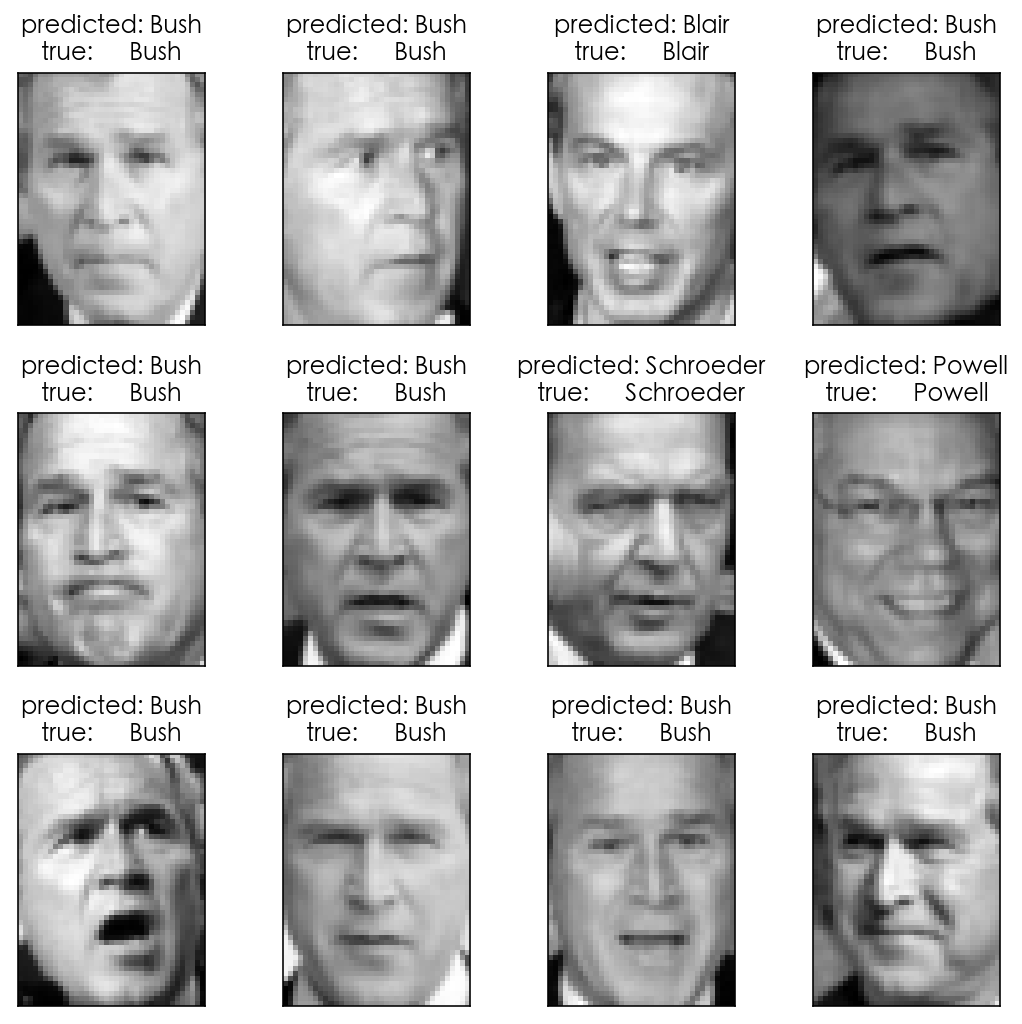

In [59]:
plot_gallery(X_test, prediction_titles, h, w)

liwei 注：可以看到，特征脸其实就是那些主成分。

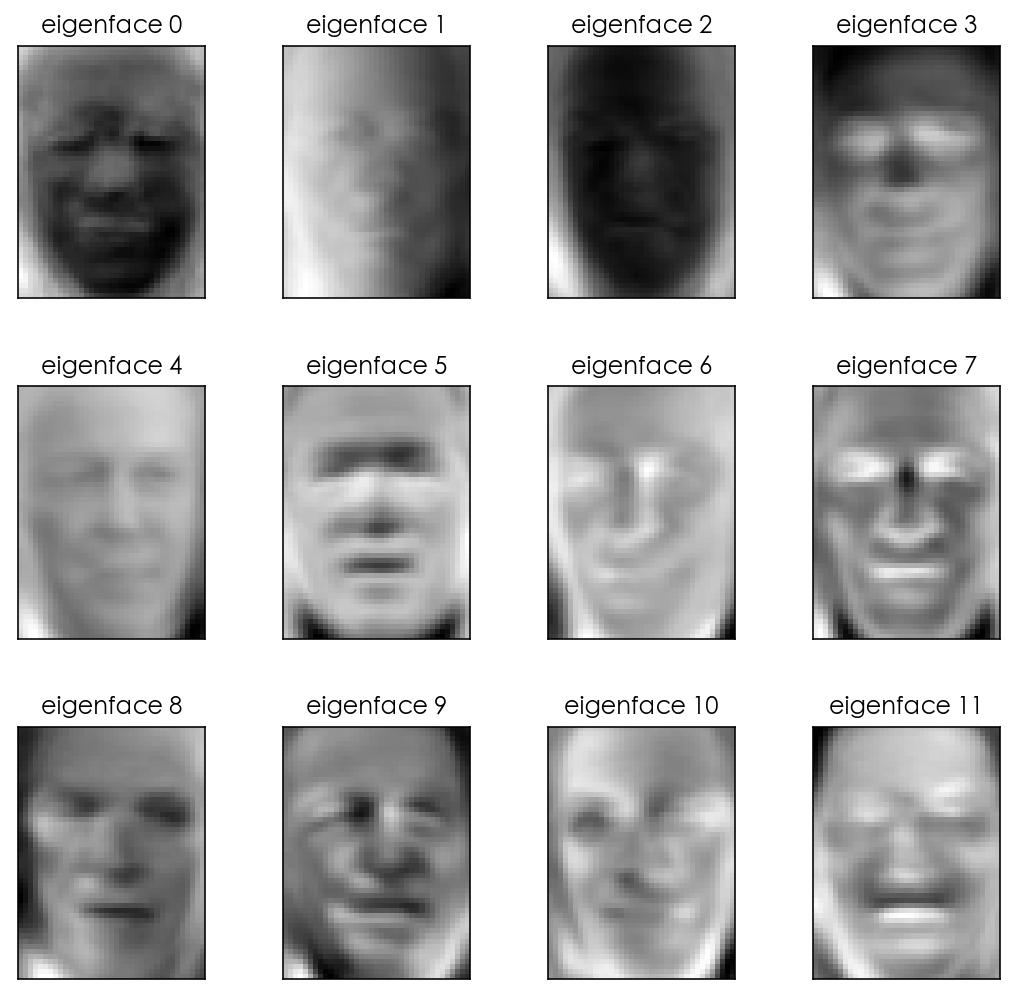

In [60]:
# plot the gallery of the most significative eigenfaces

eigenface_titles = ["eigenface %d" % i for i in range(eigenfaces.shape[0])]
plot_gallery(eigenfaces, eigenface_titles, h, w)

In [61]:
plt.show()